<a href="https://colab.research.google.com/github/bbeat2782/my_projects/blob/main/identify_songs/spotify_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("corrplot")
install.packages("glmnet")
install.packages("pls")
install.packages("mltools")
install.packages("caret")
install.packages("mctest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(boot)
library(corrplot)
library(glmnet)
library(pls)
library(MASS)
library(class)
library(mltools)
library(caret)
library(mctest)

corrplot 0.90 loaded

Loading required package: Matrix

Loaded glmnet 4.1-2


Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:stats’:

    loadings


Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:boot’:

    melanoma


Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘caret’


The following object is masked from ‘package:pls’:

    R2




In [3]:
# spotify.top2000 is the original data set that also includes variables 
# unrelated to characteristics of each songs
# spotify.top2000.s excludes Index, Artist, Top.Genre, Year from spotify.top2000

spotify.top2000 = read.csv("spotify_top_2000_over2000_sample_labeled.csv")
spotify.top2000.s = spotify.top2000[,c(3,5,8:16)]
attach(spotify.top2000.s)

In [4]:
table(spotify.top2000.s$Like)


  0   1 
227  73 

There are 73 positives out of 300 observations in the sample data set.

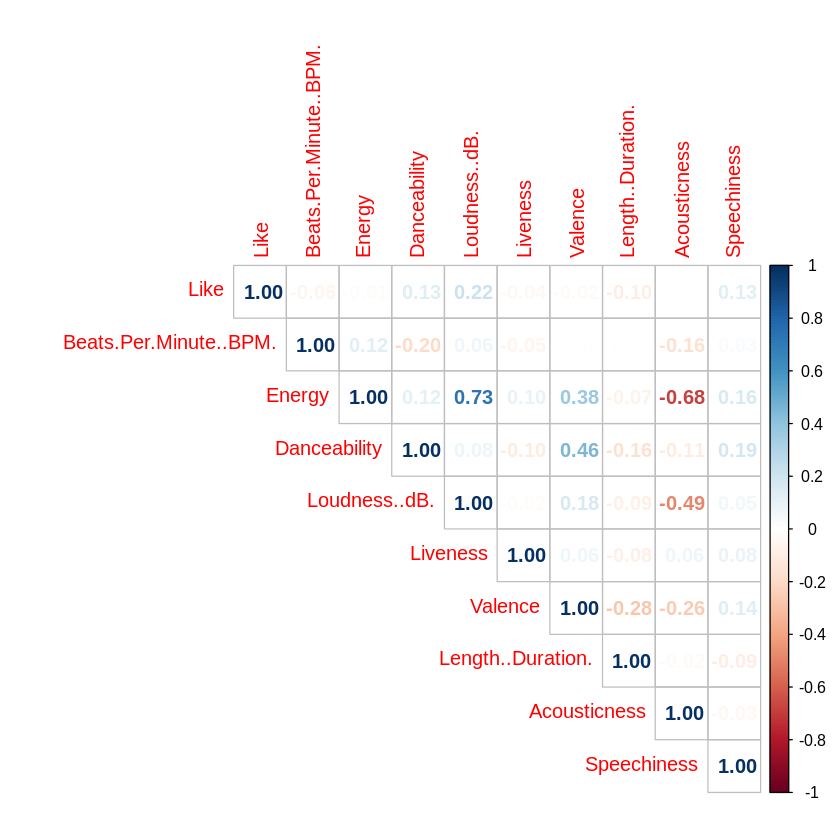

In [5]:
spotify.cor = cor(spotify.top2000.s[,-c(1)])
corrplot::corrplot(spotify.cor, method="number", type="upper")

There are slightly high collinearities between Energy & Loudness(dB) and Energy & Acousticness. However, the relationship is opposite.

In [6]:
predictors.sca = scale(spotify.top2000.s[,-c(1,2)])
response = spotify.top2000.s$Like

# set.seed(1) for reproducibility
set.seed(1)
train=sample(1:nrow(predictors.sca), nrow(predictors.sca)/2)
test = (-train)
response.test = response[test]

In [7]:
# Due to an imbalanced data set, I should use the upsampling function
# from the caret package
train.up = upSample(x=predictors.sca[train,], y=as.factor(response[train]))
colnames(train.up)[10] = "Like"

The code above is dividing the data set into the training and validation set and then applying upsampling.

The grid variable contains a range of 100 lambda values from 1e+10 to 0.01. The family=binomial argument is performing logistic regression with the glmnet(). The alpha=1 argument is applying lasso regression whereas alpha=0 is for ridge regression.




Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


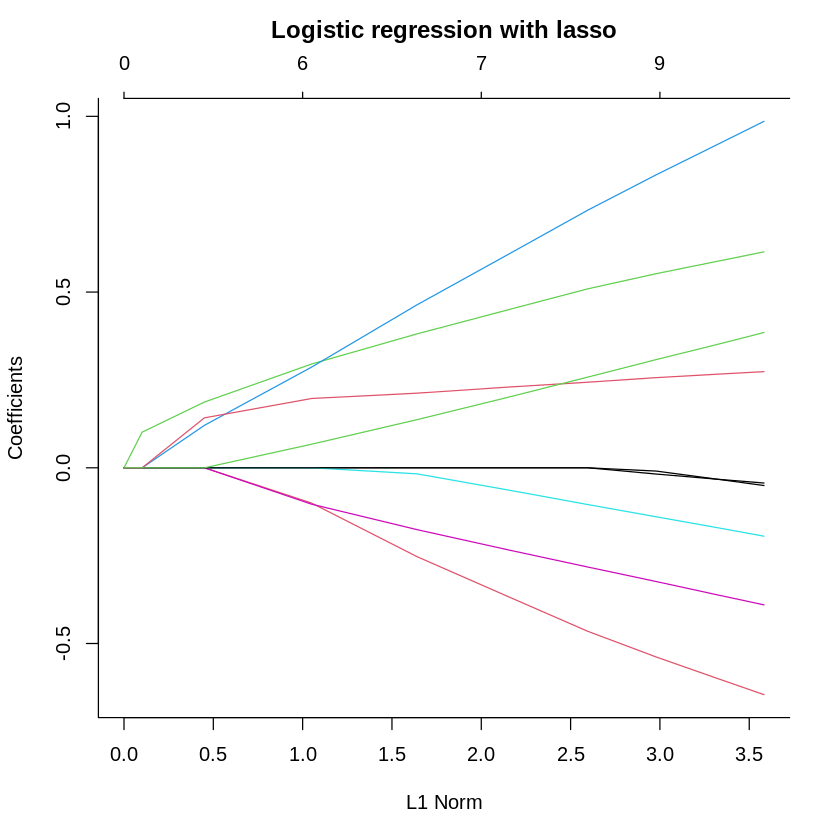

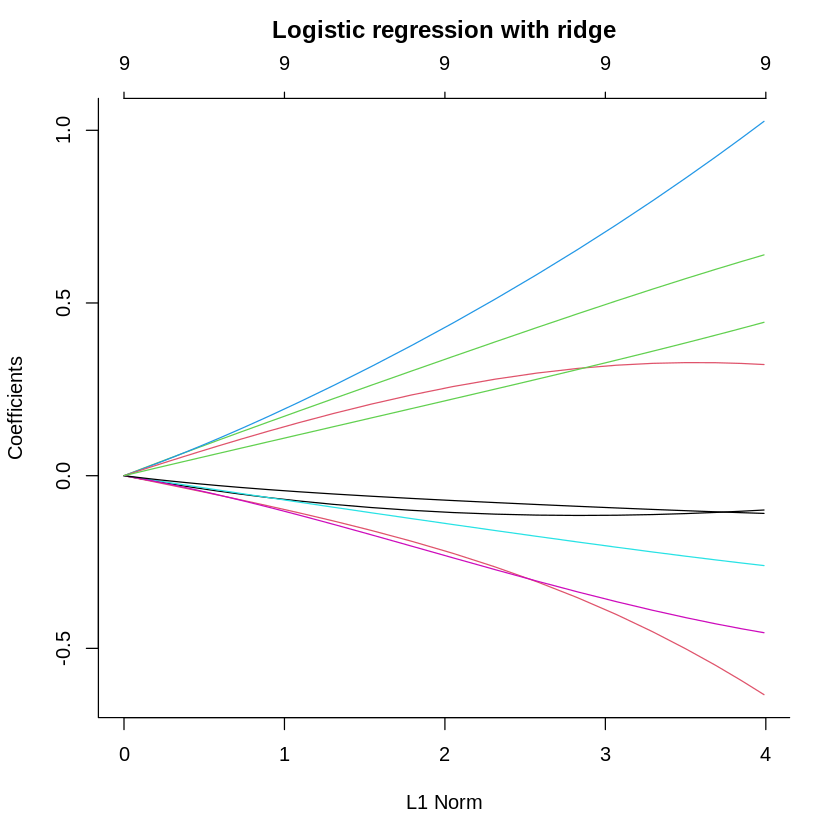

In [8]:
# performing logistic regression for classification
grid = 10^seq(10,-2,length=100)
lasso.mod = glmnet(train.up[,1:9], train.up[,10], family="binomial", alpha=1, 
                   lambda=grid)
ridge.mod = glmnet(train.up[,1:9], train.up[,10], family="binomial", alpha=0, 
                   lambda=grid)
                   
plot(lasso.mod, bty="l")
title("Logistic regression with lasso", line=2.5)
plot(ridge.mod, bty="l")
title("Logistic regression with ridge", line=2.5)

Since I'm performing classification, I want misclassified errors instead of MSE. With the type.measure="class" argument, I could use misclassified error as a metric.



In [9]:
cv.10.out = cv.glmnet(as.matrix(train.up[,1:9]), as.integer(train.up[,10]), alpha=1, 
                      family="binomial", type.measure="class")
bestlambda.l = cv.10.out$lambda.min #this gives lowest cross-validation error
lasso.probs = predict(lasso.mod, s=bestlambda.l, newx=predictors.sca[test,], 
                     type="response")

Since I chose to use f0.5 measure to evaluate which model performs better, the for loop below uses cross-validation and stores all the f0.5 measures from models with different probabilities thresholds. This is used later for identifying the best model.

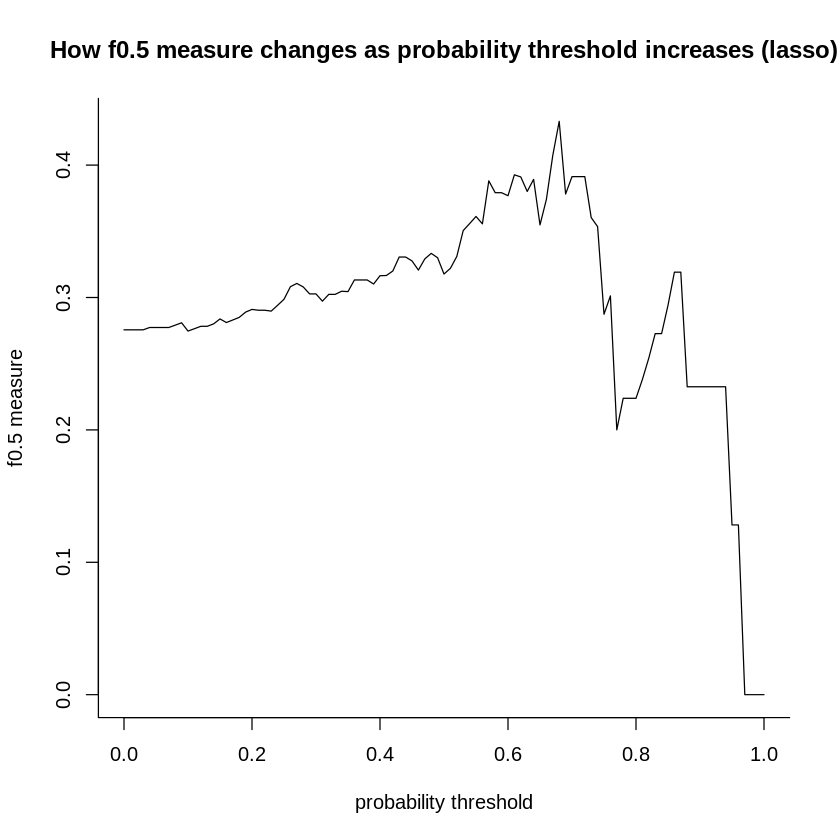

In [10]:
control.point = 0.5
probs.grid = seq(0,1,0.01)

cv.error.precision = rep(0,101)
cv.error.recall = rep(0,101)

for (i in 1:101){
  lasso.pred = rep(1, length(response.test))
  lasso.pred[lasso.probs<probs.grid[i]]=0
  t = table(lasso.pred, response.test)
  tunlike = t[1]
  flike = t[2]
  funlike = t[3]
  tlike = t[4]

  # when the probability threshold becomes extreme, only one row appears 
  # in the table. Thus, the following code handles NA values coming from
  # those cases
  if (length(t)==2){
    if (probs.grid[i]<control.point){
      tunlike = 0
      flike = t[1]
      funlike = 0
      tlike = t[2]
    }else{
      tunlike = t[1]
      flike = 0
      funlike = t[2]
      tlike = 0
    }
  }

  cv.error.precision[i] = tlike / (tlike+flike)
  cv.error.recall[i] = tlike / (tlike +funlike)
}
lasso.f0.5 = (1.25*cv.error.precision*cv.error.recall) / 
                (0.25*cv.error.precision+cv.error.recall)
lasso.f0.5[is.na(lasso.f0.5)] = 0

plot(probs.grid, lasso.f0.5, bty="l", type="l",
     xlab="probability threshold", ylab="f0.5 measure",
     main="How f0.5 measure changes as probability threshold increases (lasso)")

In [11]:
print(paste("Probability chosen by cv:",probs.grid[which.max(lasso.f0.5)]))
lasso.pred = rep(1, length(response.test))
lasso.pred[lasso.probs<probs.grid[which.max(lasso.f0.5)]]=0
table(lasso.pred, response.test)

[1] "Probability chosen by cv: 0.68"


          response.test
lasso.pred   0   1
         0 103  24
         1  12  11

Below codes are using the same process as above for ridge regression

In [12]:
cv.10.out = cv.glmnet(as.matrix(train.up[,1:9]), as.integer(train.up[,10]), alpha=0, 
                      family="binomial", type.measure="class")
bestlambda.r = cv.10.out$lambda.min
ridge.probs = predict(ridge.mod, s=bestlambda.r, newx=predictors.sca[test,], 
                     type="response")

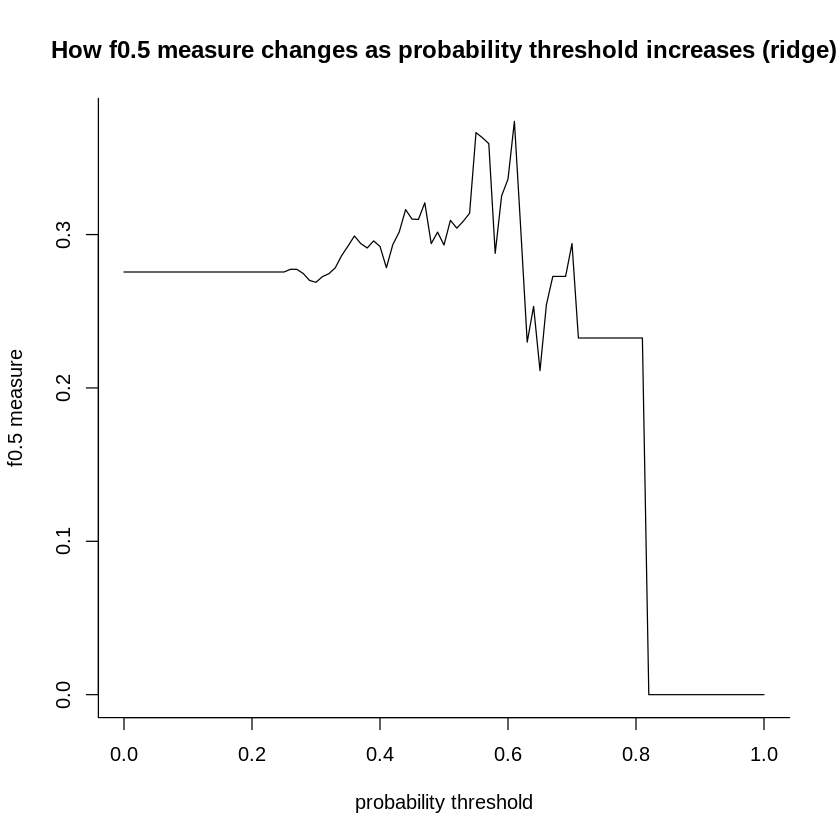

In [13]:
control.point = 0.5
probs.grid = seq(0,1,0.01)

cv.error.precision = rep(0,101)
cv.error.recall = rep(0,101)

for (i in 1:101){
  ridge.pred = rep(1, length(response.test))
  ridge.pred[ridge.probs<probs.grid[i]]=0
  t = table(ridge.pred, response.test)
  tunlike = t[1]
  flike = t[2]
  funlike = t[3]
  tlike = t[4]

  if (length(t)==2){
    if (probs.grid[i]<control.point){
      tunlike = 0
      flike = t[1]
      funlike = 0
      tlike = t[2]
    }else{
      tunlike = t[1]
      flike = 0
      funlike = t[2]
      tlike = 0
    }
  }

  cv.error.precision[i] = tlike / (tlike+flike)
  cv.error.recall[i] = tlike / (tlike +funlike)
}
ridge.f0.5 = (1.25*cv.error.precision*cv.error.recall) / 
             (0.25*cv.error.precision+cv.error.recall)
ridge.f0.5[is.na(ridge.f0.5)] = 0


plot(probs.grid, ridge.f0.5, bty="l", type="l",
     xlab="probability threshold", ylab="f0.5 measure",
     main="How f0.5 measure changes as probability threshold increases (ridge)")

In [14]:
print(paste("Probability chosen by cv:",probs.grid[which.max(ridge.f0.5)]))
ridge.pred = rep(1, length(response.test))
ridge.pred[ridge.probs<probs.grid[which.max(ridge.f0.5)]]=0
table(ridge.pred, response.test)

[1] "Probability chosen by cv: 0.61"


          response.test
ridge.pred   0   1
         0 105  27
         1  10   8

As shown below, the predict() gives probabilities that observations belong to certain classes. The default threshold it uses is 0.5, so the lda.pred$class shows classified classes based on 0.5 threshold

In [15]:
lda.fit = lda(Like~., data=spotify.top2000.s[,-c(1)], subset=train)
lda.pred = predict(lda.fit, spotify.top2000.s[test,])
lda.pred$posterior[1:5,]
lda.pred$class

,0,1
2,0.9247911,0.07520890
3,0.5545706,0.44542936
4,0.9758365,0.02416351
5,0.6833391,0.31666092
6,0.8673772,0.13262276


[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1
 [38] 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[112] 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1
[149] 0 0
Levels: 0 1

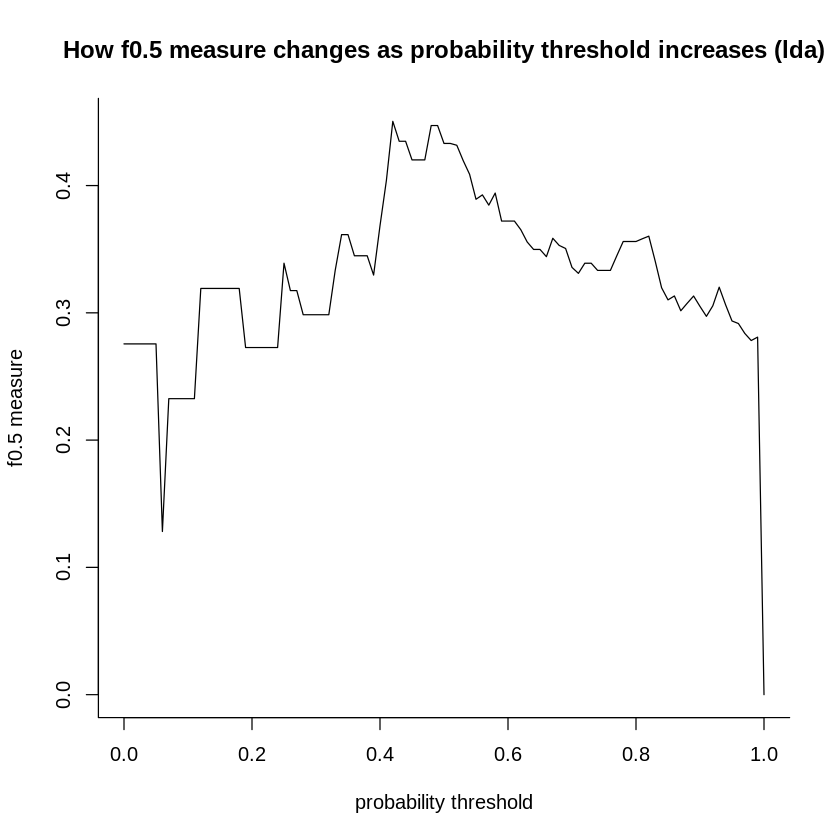

In [16]:
control.point = 0.5
probs.grid = seq(0,1,0.01)

cv.error.precision = rep(0,101)
cv.error.recall = rep(0,101)

for (i in 1:101){

  new.lda.class = rep(1, length(response.test))
  new.lda.class[lda.pred$posterior[,"0"] > probs.grid[i]] = 0
  t = table(new.lda.class, response.test)
  tunlike = t[1]
  flike = t[2]
  funlike = t[3]
  tlike = t[4]

  # when the probability threshold becomes extreme, only one row appears 
  # in the table. Thus, the following code handles NA values coming from
  # those cases
  if (length(t)==2){
    if (probs.grid[i]<control.point){
      tunlike = 0
      flike = t[1]
      funlike = 0
      tlike = t[2]
    }else{
      tunlike = t[1]
      flike = 0
      funlike = t[2]
      tlike = 0
    }
  }

  cv.error.precision[i] = tlike / (tlike+flike)
  cv.error.recall[i] = tlike / (tlike +funlike)
}
lda.f0.5 = (1.25*cv.error.precision*cv.error.recall) / 
           (0.25*cv.error.precision+cv.error.recall)
lda.f0.5[is.na(lda.f0.5)] = 0

plot(probs.grid, lda.f0.5, bty="l", type="l",
     xlab="probability threshold", ylab="f0.5 measure",
     main="How f0.5 measure changes as probability threshold increases (lda)")

In [17]:
print(paste("Probability chosen by cv:",probs.grid[which.max(lda.f0.5)]))
new.lda.class = rep(1, length(response.test))
new.lda.class[lda.pred$posterior[,"0"] > probs.grid[which.max(lda.f0.5)]] = 0
table(new.lda.class, response.test)

[1] "Probability chosen by cv: 0.42"


             response.test
new.lda.class   0   1
            0 106  25
            1   9  10

In [18]:
qda.fit = qda(Like~., data=spotify.top2000.s[,-c(1)], subset=train)
qda.pred = predict(qda.fit, spotify.top2000.s[test,])
qda.pred$posterior[1:5,]
qda.pred$class

,0,1
2,0.5202404,4.797596e-01
3,0.9999410,5.896949e-05
4,1.0000000,3.415227e-12
5,0.3291736,6.708264e-01
6,0.9998825,1.175211e-04


[1] 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1
 [38] 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1
 [75] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
[112] 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1
[149] 1 0
Levels: 0 1

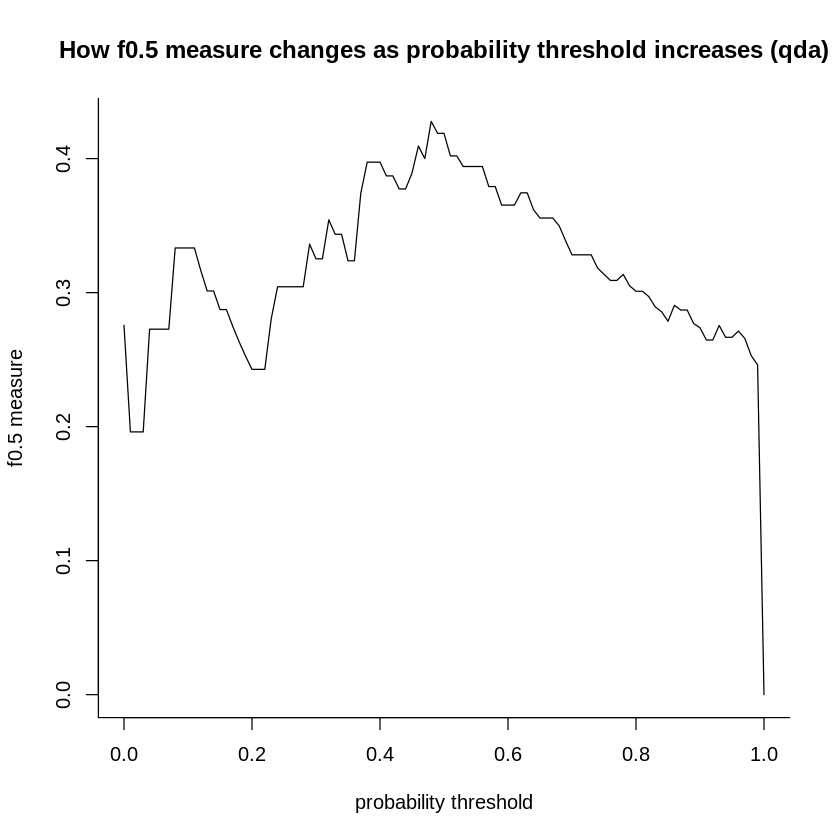

In [19]:
control.point = 0.5
probs.grid = seq(0,1,0.01)

cv.error.precision = rep(0,101)
cv.error.recall = rep(0,101)

for (i in 1:101){
  new.qda.class = rep(1, length(response.test))
  new.qda.class[qda.pred$posterior[,"0"] > probs.grid[i]] = 0
  t = table(new.qda.class, response.test)
  tunlike = t[1]
  flike = t[2]
  funlike = t[3]
  tlike = t[4]

  if (length(t)==2){
    if (probs.grid[i]<control.point){
      tunlike = 0
      flike = t[1]
      funlike = 0
      tlike = t[2]
    }else{
      tunlike = t[1]
      flike = 0
      funlike = t[2]
      tlike = 0
    }
  }

  cv.error.precision[i] = tlike / (tlike+flike)
  cv.error.recall[i] = tlike / (tlike +funlike)
}
qda.f0.5 = (1.25*cv.error.precision*cv.error.recall) / 
           (0.25*cv.error.precision+cv.error.recall)
qda.f0.5[is.na(qda.f0.5)] = 0

plot(probs.grid, qda.f0.5, bty="l", type="l",
     xlab="probability threshold", ylab="f0.5 measure",
     main="How f0.5 measure changes as probability threshold increases (qda)")

In [20]:
print(paste("Probability chosen by cv:",probs.grid[which.max(qda.f0.5)]))
new.qda.class = rep(1, length(response.test))
new.qda.class[qda.pred$posterior[,"0"] > probs.grid[which.max(qda.f0.5)]] = 0
table(new.qda.class, response.test)

[1] "Probability chosen by cv: 0.48"


             response.test
new.qda.class  0  1
            0 93 19
            1 22 16

So to sum up, 

-logistic with lasso: 12+11=23 positive results with 11 as TP --> 11/23 = 0.478

-logistic with ridge: 10+8 = 18 positive results with 8 as TP --> 8/18 = 0.444

-linear discriminant: 9+10 = 19 positive results with 10 as TP --> 10/19 = 0.526

-quadratic discriminant: 18+12 = 30 with 12 TP --> 12/30 = 0.4

Therefore, I would choose lda since even though it identifies fewer TP than qda, it gives the highest ratio of TP from outputs that are predicted positively. Thus, it gives a better user experience.